In [ ]:
!git clone https://github.com/pchlenski/gda_project/
!cd gda_project && git pull

In [20]:
# importing necessary libraries
try:
    import pycid
except ModuleNotFoundError:
    import sys

    !{sys.executable} -m pip install git+https://github.com/causalincentives/pycid # for the latest development version
    import pycid

import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from gda_project.utils.embed import *
from gda_project.utils.scm import *
from gda_project.utils.scm_large import *
import warnings
warnings.filterwarnings('ignore')

## Experiments

In [34]:
def robustness(observables,Y,embedding_dim=9,max_depth = 50):
  n_estimators = 10
  n_dims = embedding_dim
  traincount = 1600
  validcount = traincount + 400

  embed_pca = run_pca(observables, n_dims=n_dims)
  embed_isomap = run_isomap(observables, n_dims=n_dims, n_neighbors=15, eigen_solver='dense')
  embed_lle = run_lle(observables, n_dims=n_dims, n_neighbors=15, eigen_solver='dense')
  embed_laplacian = run_laplacian(observables, n_dims=n_dims, n_neighbors=15)

  reg1 = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
  reg2 = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
  reg3 = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
  reg4 = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
  reg5 = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
  reg = {"PCA":reg1,"Isomap":reg2,"LLE":reg3,"Laplacian":reg4}
  val = {}

  # print("\nObservables Validation Loss:")
  trainx = observables[:traincount]
  trainy = Y[:traincount]
  validatex = observables[traincount:validcount]
  validatey = Y[traincount:validcount]
  reg5.fit(trainx,trainy)
  val["Obs"] = np.abs(reg5.predict(validatex) - validatey).sum()/validcount
  # print(val["Obs"])

  # print("\nEmbedding Validation Loss, with embed dim: ", embedding_dim)
  for embeddings,name in [(embed_pca,"PCA"),(embed_isomap,"Isomap"),(embed_lle,"LLE"),(embed_laplacian,"Laplacian")]:
    trainx = embeddings[:traincount]
    trainy = Y[:traincount]
    validatex = embeddings[traincount:validcount]
    validatey = Y[traincount:validcount]
    reg[name].fit(trainx,trainy)
    val[name] = np.abs(reg[name].predict(validatex) - validatey).sum()/validcount
    # print(name,":", val[name])
  
  return val
  # # creating the dataset
  # data = {'Observable':val["Obs"], 'PCA':val["PCA"], 'Isomap':val['Isomap'],
  #         'LLE':val['LLE'],'Laplacian':val['Laplacian']}
  # features = list(data.keys())
  # loss = list(data.values())
    
  # fig = plt.figure(figsize = (5, 4))
  
  # # creating the bar plot
  # plt.bar(features, loss, width = 0.4, color=['black', 'maroon', 'seagreen', 'steelblue', 'gold'])
  
  # plt.xlabel("Features used for regression")
  # plt.ylabel("Validation loss")
  # plt.title("Prediction loss comparison")
  # plt.show()

### SCM-Large

In [14]:
latents_large, observables_large, Y_large = scm_large(index=1,N=2000, dropout=0.5, noise=1.0)

100%|██████████| 2000/2000 [02:57<00:00, 11.30it/s]



Observables Validation Loss:
10.337249999999996

Embedding Validation Loss, with embed dim:  9
PCA : 12.399199999999999
Isomap : 14.724549999999983
LLE : 186.965315242071
Laplacian : 173.18913797532093


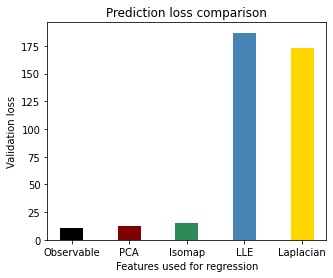

In [29]:
robustness(observables_large,Y_large)

### SCM-1

In [7]:
latents_small1, observables_small1, Y_small1 = generate_unconfounded(N=2000, dropout=0.5)


Observables Validation Loss:
0.012793849540685121

Embedding Validation Loss, with embed dim:  9
PCA : 0.012719539112474202
Isomap : 0.012970184203581123
LLE : 0.03691707117131332
Laplacian : 0.045938200792321915


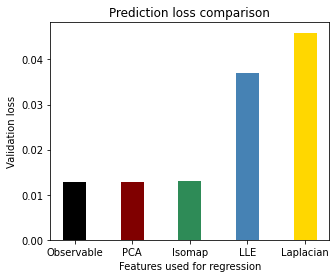

In [13]:
robustness(observables_small1,Y_small1)

### SCM-2


Observables Validation Loss:
0.012531826239804516

Embedding Validation Loss, with embed dim:  9
PCA : 0.012903598899986525
Isomap : 0.012503030596675036
LLE : 0.036401503041321295
Laplacian : 0.055604443588775906


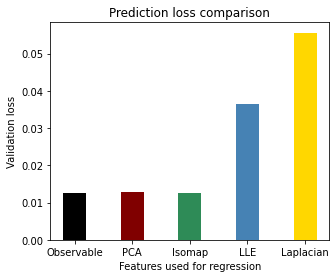

In [22]:
latents_small2, observables_small2, Y_small2 = generate_dependent(N=2000, dropout=0.5)
robustness(observables_small2,Y_small2)

# SCM-3


Observables Validation Loss:
0.013368866659655632

Embedding Validation Loss, with embed dim:  9
PCA : 0.01269791817026321
Isomap : 0.012395678322461301
LLE : 0.03654789304080775
Laplacian : 0.012698069347623513


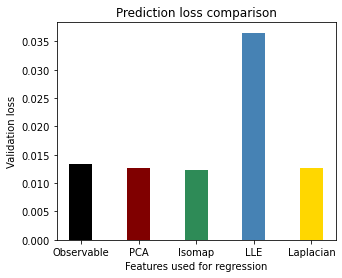

In [33]:
latents_small3, observables_small3, Y_small3 = generate_dependent(N=2000, dropout=0.85)
robustness(observables_small3,Y_small3)

### Robustness

In [35]:
validation_loss = {}
for embedding_dim in tqdm([1,2,3,4,5,6,7,8,9,10,11,12]):
  validation_loss[embedding_dim] = robustness(observables_large,Y_large, embedding_dim=embedding_dim)

100%|██████████| 12/12 [01:41<00:00,  8.48s/it]


In [36]:
Y_pca = np.zeros((12,))
Y_iso = np.zeros((12,))
Y_lle = np.zeros((12,))
Y_lap = np.zeros((12,))
for i in range(12):
  Y_pca[i] = validation_loss[i+1]['PCA']
  Y_iso[i] = validation_loss[i+1]['Isomap']
  Y_lle[i] = validation_loss[i+1]['LLE']
  Y_lap[i] = validation_loss[i+1]['Laplacian']

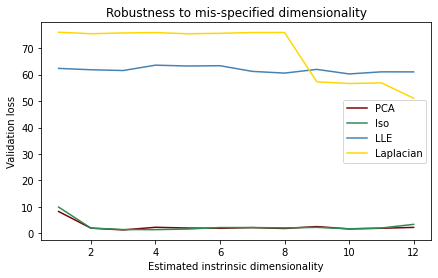

In [37]:
# creating the dataset
X = np.arange(1,13)
  
fig = plt.figure(figsize = (7, 4))

# creating the line plot
plt.plot(X, Y_pca, color='maroon',label='PCA')
plt.plot(X, Y_iso, color='seagreen',label='Iso')
plt.plot(X, Y_lle, color= 'steelblue',label='LLE')
plt.plot(X, Y_lap, color='gold',label='Laplacian')

plt.xlabel("Estimated instrinsic dimensionality")
plt.ylabel("Validation loss")
plt.title("Robustness to mis-specified dimensionality")
plt.legend()
plt.show()